In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
!unzip -q /content/gdrive/MyDrive/tinkoff/CCPD2019-dl1.zip -d Dataset

In [4]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 15.7 MB/s 


In [5]:
import os
import torch
import copy
import random 
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms
from torch.autograd import Variable
from matplotlib import colors, pyplot as plt
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)


cuda


In [6]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#### Подготовка данных для обучения

In [7]:
symbols = []
[symbols.extend(img.split('-')[-1].split('.')[0]) for img in os.listdir('/content/Dataset/CCPD2019-dl1/train')]
alphabet = set(symbols)

In [8]:
alphabet = list(alphabet)
alphabet.sort()

In [9]:
print(alphabet)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '云', '京', '冀', '吉', '宁', '川', '新', '晋', '桂', '沪', '津', '浙', '渝', '湘', '琼', '甘', '皖', '粤', '苏', '蒙', '藏', '豫', '贵', '赣', '辽', '鄂', '闽', '陕', '青', '鲁', '黑']


In [10]:
def character2index(alphabet:list) ->dict:
    """
      convert alphabet to dictionary
      alphabet - unique characters list
      return (dict) - {character: index}, index 0 reserved for 'blank' in ctc 
    """
    words_dict = dict()
    for i, item in enumerate(alphabet):
        words_dict[item] = i+1
    return words_dict

def index2character(dictionary:dict) ->dict:
    """
        reverse result for 'character2index' function
        dictionary - {character: index}, index 0 reserved for 'blank' in ctc
        return (dict) - {index: character}
    """
    return {w:k for k,w in dictionary.items()}

In [11]:
words2index = character2index(alphabet)
index2words = index2character(words2index)

На всякий случай убедимся, что длина номеров фиксированная. Это упростит жизнь при использовании CTC

In [12]:
print(set([len(i.split('-')[-1].split('.')[0]) for i in os.listdir('/content/Dataset/CCPD2019-dl1/train')]))
print(set([len(i.split('-')[-1].split('.')[0]) for i in os.listdir('/content/Dataset/CCPD2019-dl1/test')]))

{7}
{7}


In [13]:
H = 32
W = 100
MEAN = STD = .5
class OCRDataset(Dataset):
    available_modes = 'test', 'train'
    def __init__(self, dir_path:str, mode:str, label_converter):
        assert mode in self.available_modes
        assert os.path.exists(dir_path) and os.path.isdir(dir_path)
        self.dir = dir_path
        self.imgs = os.listdir(self.dir)
        self.label_converter = label_converter
        self.transform = self._transforms(mode)
    
    @staticmethod
    def _transforms(mode:str):
        if mode == 'test':
            return transforms.Compose([transforms.Resize(size = (H,W)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(MEAN, STD)])
        elif mode == 'train':
            return transforms.Compose([transforms.Resize(size = (H,W)),
                                       transforms.RandomRotation(degrees=(-5,5)),
                                       transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 1)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(MEAN, STD)])
        else:
            raise NotImplemented

    def __len__(self, ):
        return len(self.imgs)
    
    @staticmethod
    def label2list(img_name:str) -> str:
        """
            extract car number from image name
        """
        return img_name.split('-')[-1].split('.')[0]

    def label_processing(self, img_name:str):
        """
            convert img path to label
        """
        char_list = self.label2list(img_name)
        out = []
        for char in char_list:
            idx = self.label_converter[char]
            out.append(idx)
        return out

    def __getitem__(self, index) -> tuple:
        img_name = self.imgs[index]
        label = self.label_processing(img_name)
        #convert RGB 2 grey img
        img = Image.open(os.path.join(self.dir, img_name)).convert('L')
        img = self.transform(img)
        return img, label

In [14]:
train_dataset = OCRDataset('/content/Dataset/CCPD2019-dl1/train', 'train', label_converter=words2index)
test_dataset = OCRDataset('/content/Dataset/CCPD2019-dl1/test', 'test', label_converter=words2index)

Посмотрим на датасет

WORD2INDEX OUT  [52, 11, 19, 10, 12, 3, 7]
INDEX2WORD OUT  ['皖', 'A', 'J', '9', 'B', '2', '6']


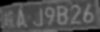

In [15]:
data = train_dataset[2]
origianl_sentence = [index2words[i] for i in data[1]]
print('WORD2INDEX OUT ', data[1])
print('INDEX2WORD OUT ', origianl_sentence)
img = data[0] * STD + MEAN
inverse_transform = transforms.ToPILImage('L')
pil_img = inverse_transform(img)
pil_img

In [16]:
#from torch.nn.utils.rnn import pad_sequence
def collate_fn(batch):
    imgs, labels = [], []
    for image, label in batch:
        imgs.append(image)
        labels.append(label)
    imgs = torch.stack(imgs, 0)
    labels = torch.as_tensor(labels, dtype=torch.long)
    return imgs, labels

In [17]:
BS = 16
test_dataloader = DataLoader(test_dataset, batch_size=BS, shuffle=False, collate_fn = collate_fn)
train_dataloader = DataLoader(train_dataset, batch_size=BS, shuffle=True, collate_fn = collate_fn)


#### Модель
Создадим модель на основе предложенного подхода из [статьи](https://arxiv.org/pdf/1507.05717.pdf): 

1.   Выделение фич из изображения - CNN
2.   Выделение лэйблов - Biderectional LSTM
3.   Транскрипт - Biderectional LSTM

##### P.S. добавление в BaseBlock residual connection слоя связано с тем, что при обучении оригинальной [модели](https://github.com/meijieru/crnn.pytorch) мне не удалось добиться точности выше 90%.

In [18]:
class RNN(nn.Module):
    def __init__(self, n_classes, lstm_in = 512, hidden_dim = 512,
                 bidirectional = None):
        super().__init__()
        self.cell = nn.LSTM(input_size = lstm_in, hidden_size = hidden_dim,
                            batch_first = True, bidirectional=bidirectional)
        if bidirectional:
            hidden_dim = 2 * hidden_dim
        self.emb = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        output, _ = self.cell(x)
        output = self.emb(output)
        return output

class BaseBlock(nn.Module):
    def __init__(self,  in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.conv_block1 = nn.Sequential(nn.Conv2d(in_channels, in_channels, 
                                        3, 1, 1, bias = False),
                                    nn.BatchNorm2d(in_channels),
                                    nn.ReLU())

        self.conv_block2 = nn.Sequential(
                                    nn.Conv2d(in_channels, out_channels, 
                                        kernel_size, stride, padding, bias=False),
                                    nn.BatchNorm2d(out_channels),
                                    nn.ReLU())
        
    def forward(self, x):
        out = x + self.conv_block1(x)
        out = self.conv_block2(out)
        return out

class CNN(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 512):
        super().__init__()
        self.conv0 = nn.Sequential(
              nn.Conv2d(in_channels, 64, kernel_size = 5, stride = 2, padding = 1, bias = False),
              nn.BatchNorm2d(64), nn.ReLU())
        self.conv1 = BaseBlock(64, 128, 3, 1, 1)
        self.conv2 = BaseBlock(128, 256, 3, 2, 1)
        self.conv3 = BaseBlock(256, 256, (3,2), (1,1), 1)
        self.conv4 = BaseBlock(256, 512, (3,3), (2,1), 1)
        self.conv5 = BaseBlock(512, 512, (3,3), (2,1), 0)

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x  # bs, 512, 1, 24

class CRNN(nn.Module):
    def __init__(self,n_classes, cnn_in_ch = 1, cnn_out_ch = 512, biderectional = True):
        super().__init__()
        self.cnn = CNN(cnn_in_ch, cnn_out_ch)
        self.seq_lab_model = RNN(cnn_out_ch, cnn_out_ch, cnn_out_ch, biderectional)
        self.transcription = RNN(n_classes, cnn_out_ch, cnn_out_ch, biderectional)

    def forward(self, x):
        features = self.cnn(x)            #bs, 1, 32, 100  -> bs, 512, 1, 24
        features = features.squeeze(2)    #bs, 512, 24
        features = features.permute(0,2,1)#bs, 24, 512
        seq_labels = self.seq_lab_model(features)
        transcript = self.transcription(seq_labels)
        return transcript                 #bs, T, cls

x = torch.randn(1, 1, 32, 100)
model = CRNN(10, 1, 512, True)
model(x).shape

torch.Size([1, 24, 10])

In [19]:
LR = 4e-4
EPOCH = 10
STEP = 2
GAMMA = 0.5
LABELS_LEN = 7                  #длина номера (см выше)
CLIP_GRAD = 10                  #пофиксить взрыв градиента
n_classes = len([*words2index])
crnn = CRNN(n_classes)
optimizer = torch.optim.Adam(crnn.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
loss_fn = torch.nn.CTCLoss()


#### Метрики
Возьмем готовую реализацию [CER](https://torchmetrics.readthedocs.io/en/stable/text/char_error_rate.html)

In [20]:
from torchmetrics import CharErrorRate
CER = CharErrorRate()
def decode(predict, blank_idx = 0, early_stop = None) ->list:
    """
        decode single predict from batch
        predict - single model predict (batch[idx])
        blank_idx - ctc 'blank' index
        early_stop (None or int) - use this param for fix result after decode predict

        return (list) - characters in label
    """
    char_list = []
    prev = None
    for idx in predict:
        if idx == blank_idx or prev == idx:
            prev = None
            continue
        char_list.append(idx)
        prev = idx
  
    if isinstance(early_stop, int) and early_stop < len(char_list):
        char_list = char_list[:early_stop]
    return char_list

def batch_decoder(predict:torch.Tensor, blank_idx:int = 0, early_stop = None) ->list:
    """
      decode model predicts
      predict - model predict 
      blank_idx - ctc 'blank' index
      early_stop (None or int) - use this param for fix result after decode predict

      return (list) - decoded model predicts
    """
    ans = []
    if isinstance(predict, torch.Tensor):
        predict = predict.tolist()
    for item in predict:
        single_pred = ans.append(decode(item, blank_idx, early_stop))
    return ans

def accuracy_plus_cer(pred_list:list, gt_list:list):
    """
      calculate accuracy and cer metrics
      pred_list - model predict in list
      gt_list - ground truth 

      return (tuple) - cer, acc 
    """
    assert len(pred_list) == len(gt_list)
    b_accuracy = 0
    b_cer = CER(pred_list, gt_list)
    for pred, gt in zip(pred_list, gt_list):
        b_accuracy += pred==gt
    return b_cer.item(), b_accuracy

In [21]:
model_out = [53, 12, 12, 0, 0, 0, 0, 4, 0, 0, 4, 4, 0, 0, 34, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 4]
gt = [53, 12, 4, 4, 34, 9, 4]
assert decode(model_out) == gt

#### Обучение

In [22]:
def train_epoch(model, train_loader, optimizer, loss_fn, device, log_period = 1000):
    model.train()
    model = model.to(device)
    losses, n_elem = 0, 0
    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        optimizer.zero_grad()
        logits = model(images)
        #prepare before ctc loss
        logits = logits.transpose(0,1)
        T, B, C = logits.shape
        n_elem += B
        preds_size = Variable(torch.IntTensor([T] * B))
        length = torch.full(size=(B,), fill_value=LABELS_LEN, dtype=torch.long)
        loss = loss_fn(logits, labels, preds_size, length)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD)
        optimizer.step()
        losses += loss.item()
        if (idx + 1) % log_period == 0:
            print('iter: {} loss = {:3.5f}'.format(idx+1, losses / n_elem))
    return losses / n_elem

def test_epoch(model, test_loader, loss_fn, device, log_period, fix_length = None):
    model.eval()
    model = model.to(device)
    cer, acc, losses, n_elem = 0, 0, 0, 0
    for idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        with torch.no_grad():
            logits = model(images)
        logits = logits.transpose(0,1)
        T, B, C = logits.shape
        n_elem += B
        preds_size = Variable(torch.IntTensor([T] * B))
        length = torch.full(size=(B,), fill_value=LABELS_LEN, dtype=torch.long)
        loss = loss_fn(logits, labels, preds_size, length)
        losses += loss.item()
        predict = torch.argmax(logits, 2).transpose(0,1)
        pred_list = batch_decoder(predict, early_stop=fix_length)
        bcer, bacc = accuracy_plus_cer(pred_list, labels.tolist())
        cer += bcer
        acc += bacc
        if (idx + 1) % log_period == 0:
            print('iter: {} CTC {:5.3f} ACC {:3.2f} CER {:3.2f}'.format(
                idx+1, losses / n_elem, acc/n_elem, cer/n_elem))
    return acc/n_elem, cer/n_elem, losses/n_elem

def fit(model, train_dataloader, test_dataloader, 
        optimizer, loss_fn, scheduler = None, 
        device = device, log_period = 1000, epoch = 5, stop = 2, 
        save_path = '/content/gdrive/MyDrive/tinkoff/'):
    unchanged_iter = 0
    best_acc = -1
    for epoch in range(epoch):
        train_loss = train_epoch(model, train_dataloader, optimizer, loss_fn, device, log_period)
        acc, cer, val_loss = test_epoch(model, test_dataloader,loss_fn, device, log_period)
        if scheduler is not None:
            scheduler.step()
        if acc > best_acc:
            unchanged_iter = 0
            best_acc = acc
            torch.save(model.state_dict(), os.path.join(save_path, 'best.pt'))
        else:
            print('test loss doesnt change or got bigger')
            unchanged_iter += 1
            if unchanged_iter == stop:
                print(f'loss does not change {stop} epoch, stop training')
                break      
        print('Epoch {} train CTC: {:5.3f} val CTC: {:5.3f} CER: {:6.4f} Accuracy: {:6.4f}'.format(
            epoch+1, train_loss, val_loss, cer, acc))



In [23]:
fit(crnn, train_dataloader, test_dataloader, optimizer, loss_fn, scheduler, 
    device, 2000, EPOCH, 2)

iter: 2000 loss = 0.08540
iter: 4000 loss = 0.04499
iter: 6000 loss = 0.03083
iter: 8000 loss = 0.02359
iter: 10000 loss = 0.01918
iter: 12000 loss = 0.01620
Epoch 1 train CTC: 0.016 val CTC: 0.004 CER: 0.0003 Accuracy: 0.9686
iter: 2000 loss = 0.00105
iter: 4000 loss = 0.00103
iter: 6000 loss = 0.00096
iter: 8000 loss = 0.00094
iter: 10000 loss = 0.00090
iter: 12000 loss = 0.00087
Epoch 2 train CTC: 0.001 val CTC: 0.002 CER: 0.0003 Accuracy: 0.9731
iter: 2000 loss = 0.00039
iter: 4000 loss = 0.00038
iter: 6000 loss = 0.00036
iter: 8000 loss = 0.00034
iter: 10000 loss = 0.00034
iter: 12000 loss = 0.00033
Epoch 3 train CTC: 0.000 val CTC: 0.001 CER: 0.0002 Accuracy: 0.9794
iter: 2000 loss = 0.00027
iter: 4000 loss = 0.00028
iter: 6000 loss = 0.00027
iter: 8000 loss = 0.00028
iter: 10000 loss = 0.00027
iter: 12000 loss = 0.00028
test loss doesnt change or got bigger
Epoch 4 train CTC: 0.000 val CTC: 0.000 CER: 0.0003 Accuracy: 0.9660
iter: 2000 loss = 0.00025
iter: 4000 loss = 0.00022
it

In [24]:
model = crnn.load_state_dict(torch.load('/content/gdrive/MyDrive/tinkoff/best.pt', 'cpu'))

In [25]:
acc, cer, val_loss = test_epoch(crnn, test_dataloader,loss_fn, device, 1000)
print('test acc {:5.3f}%, test cer {:5.3f}%'.format(acc * 100, cer * 100))

test acc 98.930%, test cer 0.011%


In [26]:
def bad_cases(model,
              target_value:float = 0,
              metric_name:str = 'acc',
              max_examples = 100, verbose = True):
    model.eval()
    model.to('cpu')
    boundary_cases_list = []
    for i in range(max_examples):
        wrong = False
        image, label = test_dataset[i]
        tensor = image.unsqueeze(0)
        with torch.no_grad():
            pred = model(tensor)
        pred_idxs = torch.argmax(pred, 2).tolist()
        pred_idxs = decode(pred_idxs[0])
        cer, acc = accuracy_plus_cer([pred_idxs], [label])
        if metric_name == 'cer':
            if cer < target_value:
                wrong = True
                boundary_cases_list.append([image, label, pred_idxs])
        elif metric_name == 'acc':
            if not acc:
                wrong = True
                boundary_cases_list.append([image, label, pred_idxs])
        else:
            raise NotImplementedError()
        if verbose and wrong:
            print('wrong model answer!\npredict: {} gt: {}'.format(
                pred_idxs, label))

    return boundary_cases_list

bad_cases_list = bad_cases(crnn, max_examples = 1000)

wrong model answer!
predict: [52, 11, 11, 10, 2, 6, 13] gt: [52, 11, 19, 10, 2, 6, 13]
wrong model answer!
predict: [52, 11, 15, 2, 4, 1, 14] gt: [52, 11, 21, 2, 4, 1, 14]
wrong model answer!
predict: [38, 11, 20, 6, 6, 7, 22] gt: [66, 11, 20, 6, 6, 7, 22]
wrong model answer!
predict: [52, 11, 10, 9, 7, 35, 7] gt: [52, 11, 10, 9, 7, 8, 7]
wrong model answer!
predict: [52, 11, 25, 10, 1, 2, 8] gt: [52, 11, 25, 10, 1, 2, 29]
wrong model answer!
predict: [54, 13, 19, 1, 12, 2, 3] gt: [47, 13, 19, 1, 12, 2, 3]
wrong model answer!
predict: [52, 11, 23, 7, 3, 6, 6] gt: [42, 11, 23, 7, 3, 6, 6]
wrong model answer!
predict: [61, 13, 19, 1, 1, 1, 2] gt: [62, 13, 19, 1, 1, 1, 2]
wrong model answer!
predict: [52, 11, 29, 6, 4, 22, 9] gt: [52, 11, 2, 6, 4, 22, 9]
wrong model answer!
predict: [52, 11, 33, 7, 34, 3, 26] gt: [52, 11, 33, 7, 34, 3, 1]
wrong model answer!
predict: [52, 12, 15, 8, 7, 8, 32] gt: [54, 12, 15, 8, 7, 8, 32]
wrong model answer!
predict: [52, 11, 20, 4, 7, 10, 22] gt: [52, 11

Посмотрим на несколько ошибок подробнее

In [29]:
print(index2words[10] + '->' + index2words[19])
print(index2words[34] + '->' + index2words[29])
print(index2words[14] + '->' + index2words[1])
print(index2words[13] + '->' + index2words[1])
print(index2words[35] + '->' + index2words[8])
print(index2words[10] + '->' + index2words[28])
print(index2words[26] + '->' + index2words[1])

9->J
Y->T
D->0
C->0
Z->7
9->S
Q->0


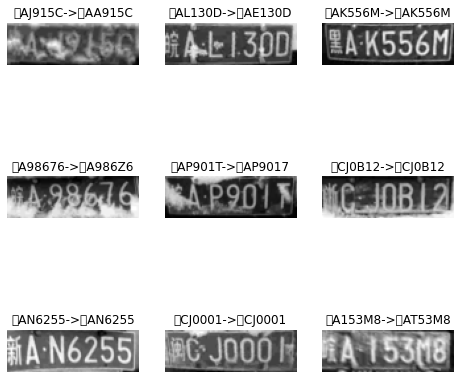

In [30]:
import warnings
warnings.filterwarnings("ignore")
MAX_EXAMPLES = 9
def show_wrong_ans(bad_cases_list:list, converter:dict):
    fig = plt.figure(figsize=(8,8))
    for i in range(min(len(bad_cases_list), MAX_EXAMPLES)):
        a = fig.add_subplot(3, 3, i + 1)
        plt.axis('off')
        img, gt, predict = bad_cases_list[i]
        img = img * STD + MEAN
        img = inverse_transform(img)
        gt_str = ''.join([converter[idx] for idx in gt]) 
        pred_str = ''.join([converter[idx] for idx in predict])
        label = gt_str +'->'+ pred_str
        plt.title(label)
        plt.imshow(img, cmap='gray')
    plt.show()
show_wrong_ans(bad_cases_list, index2words)

Предложенный baseline работает достаточно хорошо, как можно видеть ошибки модели связаны в первую очередь с низким качеством изображения (в случаях, когда пропущен символ). Второй тип ошибок - похоже символы, например D, O, 0 или 7 и Z. Этот тип ошибок можно исправить, если использовать более глубокую сверточную сеть, для лучшего выделения фич из изображения номера. Третий тип ошибок - неправильное определение первого символа (иероглифа). Возможно в датасете есть дисбаланс:
 


In [31]:
hieroglifs = dict()
for image_name in os.listdir('/content/Dataset/CCPD2019-dl1/train/'):
    hieroglif = image_name.split('-')[-1][0]
    if hieroglifs.get(hieroglif) is None:
        hieroglifs[hieroglif] = 1
    else:
        hieroglifs[hieroglif] +=1

In [32]:
values = list(hieroglifs.values())

Возможно гистограмма не совсем понятна. На ней показан дисбаланс представленных классов, в нашем случае, иероглифов. Один иероглиф представлен более 175000 раз, в то время как оставшиеся пресдставлены в менее чем 5000 изображениях. Это одна из причин почему модель ошибается в классификации иероглифа.

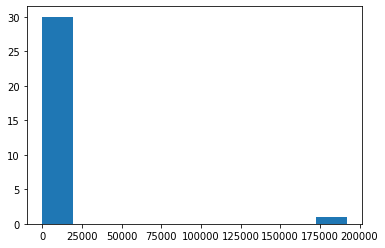

In [33]:
n, bin, patches = plt.hist(values, bins = 10)
plt.show()

In [34]:
#то же самое в более удобном виде
hieroglifs

{'皖': 191796,
 '苏': 3311,
 '沪': 663,
 '粤': 373,
 '闽': 208,
 '豫': 431,
 '川': 121,
 '浙': 1349,
 '京': 307,
 '鲁': 248,
 '鄂': 278,
 '冀': 175,
 '青': 11,
 '赣': 151,
 '晋': 67,
 '渝': 74,
 '辽': 59,
 '云': 17,
 '陕': 55,
 '湘': 96,
 '蒙': 19,
 '黑': 18,
 '吉': 13,
 '津': 60,
 '甘': 18,
 '琼': 9,
 '桂': 15,
 '宁': 5,
 '贵': 16,
 '新': 16,
 '藏': 1}

Соответсвенно, чтобы уменьшить ошибку определения иероглифа нужно добавить в датасет изображения с другими иероглифами.